In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
# Get the df from before
%run mass_df.ipynb

Now you have the file massround.mas20.txt in the pd.DataFrame() -> df


In [3]:
float(df.query("A == 2")["Binding Energy/A (keV)"].values[0])*2

2224.566

In [4]:
df

,N,Z,A,El,Orig,Mass Excess (keV),ME Unc,Binding Energy/A (keV),BE/A Unc,Beta-decay Type,Beta-decay Energy (keV),BE Unc,N Protons,Atomic Mass (micro-u),AM Unc
0,1,0,1,n,,8071.3181,0.0004,0.0,0.0,B-,782.347,a,1,008664.9159,0.0005
1,0,1,1,H,,7288.97106,0.00001,0.0,0.0,,*,,1,007825.03190,0.00001
2,1,1,2,H,,13135.72290,0.00002,1112.283,a,,*,,2,014101.77784,0.00002
3,2,1,3,H,,14949.81090,0.00008,2827.265,a,B-,18.592,a,3,016049.28132,0.00008
4,1,2,3,He,,14931.21888,0.00006,2572.680,a,,*,,3,016029.32197,0.00006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,176,117,293,Ts,-a,194430#,780#,7095#,3#,B+,3860#,930#,293,208730#,840#
3554,175,118,293,Og,-a,198800#,710#,7078#,2#,B+,4370#,1050#,293,213420#,760#
3555,177,117,294,Ts,-a,196400#,590#,7092#,2#,,*,,294,210840#,640#
3556,176,118,294,Og,-a,199320#,550#,7079#,2#,B+,2920#,810#,294,213980#,590#


In [35]:
def func(U_0: float, A: int) -> float:
    reduced_m_d = 469.48968  # MeV / c²
    bound_energy = df.query(f"A == {A}")["Binding Energy/A (keV)"].str.replace("#", "").astype(float).mean() * A * 1e-3  # MeV
    hbarc = 197.327  # MeV * fm
    R = 1.4 * A **(1/3) if A != 2 else 1.7  # fm
    k1 = np.sqrt(2 * reduced_m_d * (U_0 - bound_energy)) / hbarc
    k2 = np.sqrt(2 * reduced_m_d * bound_energy) / hbarc
    output = 1 / k1 * np.tan(k1 * R) + 1 / k2
    return output

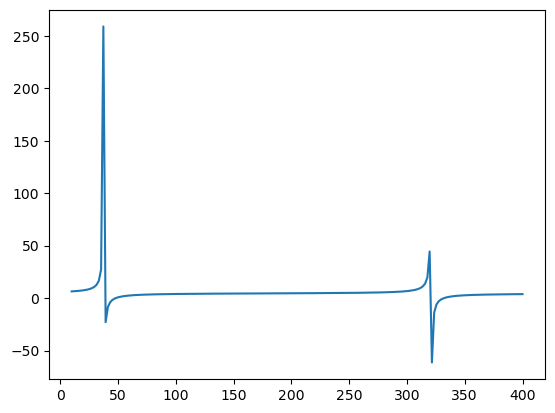

In [36]:
U_0s = np.linspace(10,400, 200)
plt.plot(U_0s, func(U_0s, 2))
#plt.xlim(40,50)
plt.show()

In [37]:
U_0_value = fsolve(func, 47, 2)[0]
U_0_value

48.07663963942759

In [8]:
def full_eq(r: float, U_0: float) -> float:
    reduced_m_d = 469.48968  # MeV/c²
    bound_energy = 2.2 # MeV Brug mass filen til at få denne energi ind
    hbarc = 197.327 # MeV*fm
    R = 1.7 # fm
    k1 = np.sqrt(2 * reduced_m_d * (U_0 - bound_energy)) / hbarc
    k2 = np.sqrt(2 * reduced_m_d * bound_energy) / hbarc
    
    A = 1
    R_fm = R
    if r < R_fm:
        output = A * np.sin(k1 * r)
    elif r >= R_fm:
        B = A * np.sin(k1 * R) / np.exp(-k2 * R)
        output = B * np.exp(-k2 * r)
    else:
        output = 0
        print("error")
        
    return output
    

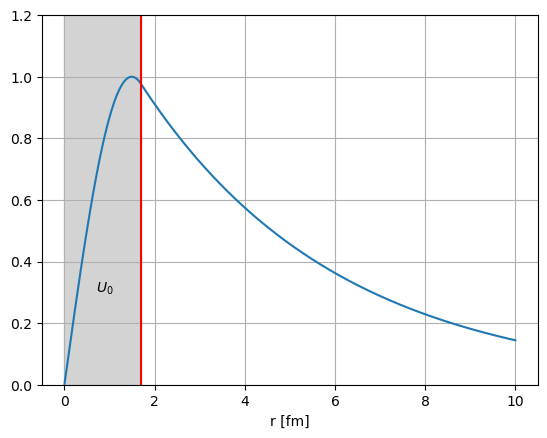

In [9]:
rs = np.linspace(0, 10, 300)
wavefunc = [full_eq(r, U_0_value) for r in rs]
plt.plot(rs, wavefunc)
plt.axvline(1.7,color='r', label="R")
plt.fill_betweenx([-2,2],[1.7,1.7], color="lightgrey")
plt.xlabel("r [fm]")
plt.annotate('$U_0$', [0.7,0.3])
plt.ylim(0, 1.2)
plt.grid()
plt.show()

# B

In [10]:
#  Python version of Jacob Johansen's square-well program   19/5-2020
#
#  The program calculates energy eigenvalues for a neutron in a square well
#  nuclear potential with radius R = 1.4 * A^(1/3) fm
#  Units  -  MeV, fm
#  Input:     all scalar
#    V0 - depth of the well in MeV
#    A  - total number of nucleons for the potential
#    l  - angular momentum
#  Output:
#    E  - energy eigenvalues

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

# numerical constants - PDG 2018
hbarc = 197.3269788
me = 0.510998946
mp = 938.272081
mn = 939.565413
finest = 1/137.03599914

mhbar = 2.*mn/hbarc**2

V0 = 40.
A = 2
l = 0

# find energies in E-list just below a fullfilled matching condition
def zeropoint(E,V0,A,l):
    r0 = 1.4*A**(1./3.)
    kr = np.sqrt(mhbar*(V0-abs(E)))*r0
    kapr = np.sqrt(mhbar*abs(E))*r0
    indre = kr*sc.spherical_jn(l,kr,derivative=True)/sc.spherical_jn(l,kr)
    ydre = kapr*sc.spherical_kn(l,kapr,derivative=True)/sc.spherical_kn(l,kapr)
    egenligning = indre - ydre
    signchange = egenligning[0:len(E)-1]*egenligning[1:len(E)]
    # signchange is small and negative at matching points, but also large
    #   when "the tangent diverges"...
    eresult = []
    [eresult.append(E[i]) for i in range(len(E)-1) if signchange[i]<0 and abs(egenligning[i])<10]
    return eresult

# first find all solutions with 0.1 MeV resolution
E1 = np.linspace(-1*V0+.1,-0.1,10*int(V0)-1)
Eres = zeropoint(E1,V0,A,l)
#print(Eres)

# then refine each solution to 0.1 keV
Efinal = []
for j in range(len(Eres)):
    E2 = np.linspace(Eres[j],Eres[j]+0.1,num=1000,endpoint=False)
    Ehelp = zeropoint(E2,V0,A,l)
    Efinal.append(Ehelp[0])

print('A:',A,' V0:',V0,' l:',l)
print(Efinal)

Give A value: 2
A: 2  V0: 40.0  l: 0
[-10.4362]


In [11]:
As = np.arange(1, 250, 1)
Es = []


for A in As:
    # first find all solutions with 0.1 MeV resolution
    E1 = np.linspace(-1*V0+.1,-0.1,10*int(V0)-1)
    Eres = zeropoint(E1,V0,A,l)
    #print(Eres)

    # then refine each solution to 0.1 keV
    Efinal = []
    for j in range(len(Eres)):
        E2 = np.linspace(Eres[j],Eres[j]+0.1,num=1000,endpoint=False)
        Ehelp = zeropoint(E2,V0,A,l)
        Efinal.append(Ehelp[0])
    Es.append(Efinal)
    
    

In [12]:
df_e = pd.DataFrame({"A": As, "Energylevels": Es})

In [13]:
def expand_list(row: list) -> pd.Series:
    max_len = max(map(len, row))
    return pd.Series(row[0] + [None] * (max_len - len(row[0])))

expanded_df = df_e[["Energylevels"]].apply(expand_list, axis=1)

In [14]:
for col in expanded_df.columns:
    df_e[col] = expanded_df[col]

In [15]:
t_es = df.loc[df["A"].isin(As)].copy()
t_es["Binding Energy/A (keV)"] = t_es["Binding Energy/A (keV)"].str.replace("#", "").astype(float)
#t_es["Binding Energy/A (keV)"] = t_es["Binding Energy/A (keV)"] * t_es["A"]

In [16]:
es = [t_es.loc[t_es["A"] == A, "Binding Energy/A (keV)"].max() for A in As]

In [17]:
t_es.query("A == 5")

,N,Z,A,El,Orig,Mass Excess (keV),ME Unc,Binding Energy/A (keV),BE/A Unc,Beta-decay Type,Beta-decay Energy (keV),BE Unc,N Protons,Atomic Mass (micro-u),AM Unc
9,4,1,5,H,-nn,32890,90,1336.0,18,B-,21660,90,5,035310,100
10,3,2,5,He,-n,11231,20,5512.0,4,,*,,5,012057,21
11,2,3,5,Li,-p,11680,50,5266.0,10,B+,450,50,5,012540,50
12,1,4,5,Be,x,37140#,2000#,20.0,400#,B+,25460#,2000#,5,039870#,2150#


In [18]:
# Part of C, but works here
def get_A(n: int) -> float:
    reduced_m_neutron = 940.6  # MeV / c²
    hbarc = 197.327  # MeV * fm
    U_0 = 40  # MeV
    k1 = np.sqrt(2 * reduced_m_neutron * (U_0)) / hbarc
    output = ((n * np.pi) / (k1 * 2 * 1.4))**3
    return output
ns = np.arange(1,9,2)
A_computed = get_A(ns)

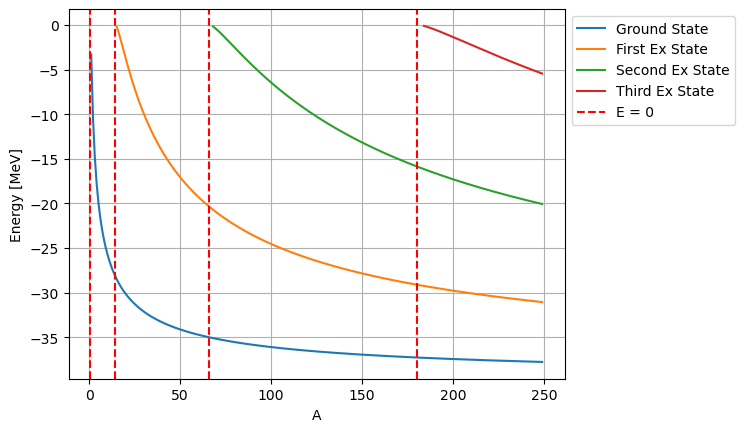

In [43]:
plt.plot(df_e["A"], df_e[0], label="Ground State")
plt.plot(df_e["A"], df_e[1], label="First Ex State")
plt.plot(df_e["A"], df_e[2], label="Second Ex State")
plt.plot(df_e["A"], df_e[3], label="Third Ex State")
# plt.plot(As, np.array(es)*-1*1e-3, label="Theoretical Data")
plt.xlabel("A")
plt.ylabel("Energy [MeV]")
plt.grid()
for A in A_computed:
    if A == A_computed[0]:
        plt.axvline(A, color='r', linestyle="--", label="E = 0")
    else:
        plt.axvline(A, color='r', linestyle="--")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [47]:
df_e

,A,Energylevels,0,1,2,3
0,1,[-3.3147999999999986],-3.3148,NaN,NaN,NaN
1,2,[-10.4362],-10.4362,NaN,NaN,NaN
2,3,[-14.828800000000003],-14.8288,NaN,NaN,NaN
3,4,[-17.7898],-17.7898,NaN,NaN,NaN
4,5,[-19.949199999999998],-19.9492,NaN,NaN,NaN
...,...,...,...,...,...,...
244,245,"[-37.727799999999995, -30.9555, -19.8626999999...",-37.7278,-30.9555,-19.8627,-5.1414
245,246,"[-37.7335, -30.977999999999998, -19.9116, -5.2...",-37.7335,-30.9780,-19.9116,-5.2183
246,247,"[-37.73909999999999, -31.0003, -19.9602, -5.29...",-37.7391,-31.0003,-19.9602,-5.2950
247,248,"[-37.744699999999995, -31.0224, -20.0086, -5.3...",-37.7447,-31.0224,-20.0086,-5.3712


In [20]:
df_e.loc[df_e[1] > -0.5]

,A,Energylevels,0,1,2,3
14,15,"[-28.474899999999998, -0.20830000000000426]",-28.4749,-0.2083,NaN,NaN


In [21]:
df_e.loc[df_e[2] > -0.2]

,A,Energylevels,0,1,2,3
67,68,"[-35.0837, -20.697499999999998, -0.18140000000...",-35.0837,-20.6975,-0.1814,NaN


In [22]:
df_e.loc[df_e[3] > -0.15]

,A,Energylevels,0,1,2,3
183,184,"[-37.2925, -29.240599999999997, -16.1516999999...",-37.2925,-29.2406,-16.1517,-0.1105


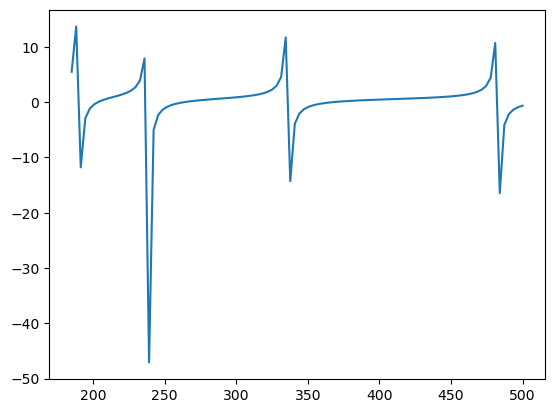

In [23]:
U_0s = np.linspace(185,500, 100)
plt.plot(U_0s, func(U_0s, 25))
#plt.xlim(40,50)
plt.show()

# C

In [24]:
def book_eq_3_47(R: float):
    """
    kR = pi/2
    and it then follows that
    """
    m = 469.48968 
    U_cr = np.pi**2 * hbarc**2 / (8 * m * R**2)
    return U_cr

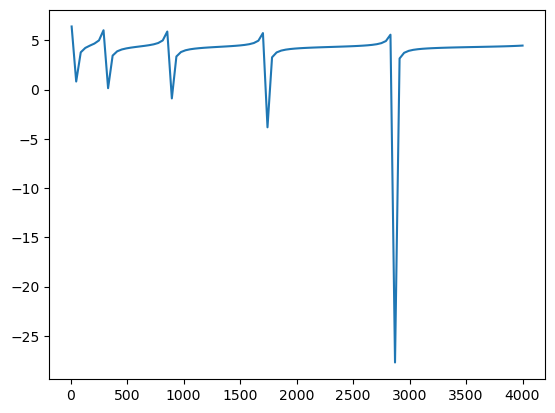

In [25]:
# It can be seen on this graph that for a higher U_0 can support a large R such kR = pi /2 
U_0s = np.linspace(10,4000, 100)
plt.plot(U_0s, func(U_0s, 2))
#plt.xlim(40,50)
plt.show()
# You can see this periodicy

In [26]:
book_eq_3_47(1.7)

35.404527153647386

In [27]:
def get_A(n: int) -> float:
    reduced_m_neutron = 940.6  # MeV / c²
    hbarc = 197.327  # MeV * fm
    U_0 = 40  # MeV
    k1 = np.sqrt(2 * reduced_m_neutron * (U_0)) / hbarc
    output = ((n * np.pi) / (k1 * 2 * 1.4))**3
    return output

In [51]:
A_bessel = [df_e.loc[df_e[i] > -10, "A"].values[0] for i in range(4)]

In [52]:
ns[1:], A_bessel

(array([3, 5, 7]), [1, 15, 68, 184])

In [54]:
pd.DataFrame({"n": ns, "A (E = 0)": A_computed, "A (from bessel E closest to 0)": A_bessel})

,n,A (E = 0),A (from bessel E closest to 0)
0,1,0.525766,1
1,3,14.195686,15
2,5,65.720769,68
3,7,180.337789,184


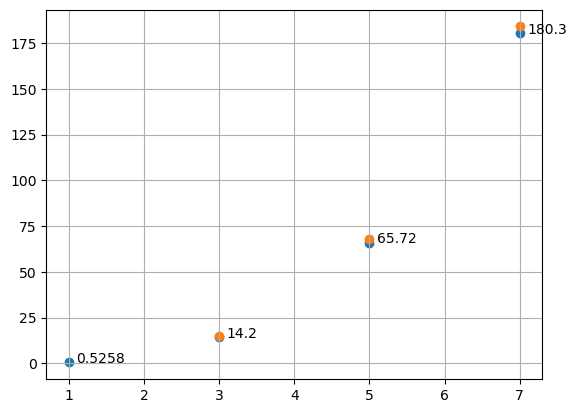

In [31]:
plt.scatter(ns, A_computed)
plt.scatter(ns[1:], A_bessel)
for i in range(len(ns)):
    plt.annotate(xy=[ns[i]+ 0.1, A_computed[i]], text=f"{A_computed[i]:.4}")
    
plt.grid()
plt.show()